## TP3: Reconnaissance de signaux de communication par apprentissage profond

Students:
- Mathilde Dupouy
- Balthazar Neveu

### Note
- Code is located in scripts.  *Follow the :star: if you need  to review the code.*
- Code works on both linux and windows
- Our code is available on [github](https://github.com/balthazarneveu/MVA23_SIGNAL)

----------------------------------



# TL/DR Comparing performances between models
We achieve an overall final performance of 85.2% on the validation set.

In the following graph:
- `Vanilla` : <40%. we started from dumb baselines  (`Vanilla Convolutional Classifier` and `Vanilla RNN`).
- `SlimConv` : 78.2% then we focused on improving the convolutional baseline  (and iterated on hyperparemeters to reach -80%)
- `FlexConv` : 83.4% we experimented with architecture exploration and made the models independant from the signal length... we trained untill we started overfitting. We also tried bigger networks.
- `FlexConv+Fine Tune` : **85.2%** We finally fine-tuned the pretrained `FlexConv` model (from checkpoint before it started overfitting) and added a few signal augmentations to improve the performances a bit more.



![](figures/summary_accuracy_with_regard_to_SNR.png)

We also report the final confusion matrices.
![](figures/confmatrix_exp66.png)



## 1. Data analyzis

#### Data loader
> :star: code [`data_loader.py`](data_loader.py)

- We can filter on the SNR we want, which will be usefull when we want to evaluate the model performances.
- Since a mild amount data is available, we believed at first that it would be useful to be able to augment this dataset synthetically. Therefore, the Dataloader allows 2 kinds of orientations:
  - rotate the complex signals
  - add a big of AWGN (additive white gaussian noise) in $\mathcal{N}(\mu=0, \sigma^2)$ where we can sample the standard deviation uniformly $\sigma \sim \mathcal{U}[0, \sigma_{\text{max}}]$. We'd add noise on top of noise, but why not as long as the goal is to try to try to let the network generalize better. Ideally, one would use the AWGN augmentation on clean signals (in our case, what is most close to it are the 30dB signals).
  - We also provide an augmentation to trim randomly the sequence (which requires a `collate function` to reconstruct batches of equal temporal length). This augmentation is only valid if the network does not depend on the length of the sequence (e.g RNN or a CNN with global pooling layers).


![](figures/augmentation_by_rotations.png)



|SNR | Training samples: Total 30k samples | Validation samples: Total 10k samples |
|:---:|:---:|:---:|
|0db|7660 | 2460|
|10db|7640 | 2520|
|20db|7020 | 2420|
|30db|7680 | 2600|

#### Data analysis
The signals are from 6 classes depending on their modulation type, the pilot sequences (presence or not, protocol of alternance with the meaningful data), and the transmission rate. Thus the time is of huge importance in the signal has two types of sequences can alternate sequentially, the transmission rate is lost during demodulation but the frequency bandwidth arond 0 may differ.
As the signals are represented by IQ signals, a good representation is a plot in the complex plane, hence it reveals the different constellation used, for exemple isotropic or not, or rotated due to the noise from transposition. As the signals are the SNR of the data is available, we can also qualitatively see that the quality of the observed constellation is low for low SNRs (for instance 0 dB, the signal and the noise have the same power). An exemple for the class N-QAM16 is illustrated below, Figure 1 and 2. For a SNR of 30dB, the density is concentrated around a rotated grid : this is the constellation. There is a distribuion of points outside the constaellation that can be due to the inference received from non-direct trajectories;

<div style="display: flex; flex-direction: row;">
    <figure>
        <img src="figures/data_NQAM16_SNR0.png" alt="Figure 1" width="400"/>
        <figcaption>Signal from class N-QAM16 with a SNR of 0dB. </figcaption>
    </figure>
    <figure>
        <img src="figures/data_NQAM16_SNR30.png" alt="Figure 2" width="400"/>
        <figcaption>Signal from class N-QAM16 with a SNR of 0dB.</figcaption>
    </figure>
</div>



:mag: Please refer to the section **Visualize dataset** at the bottom of the notebook to get more information and *visualize a few signals*.




## 2. Methodology
### Training and evaluation frameworks


> :star: [`training.py`](training.py) contains the training loop. Validation metrics are evaluated after each epoch.


`training.py` offers a command line interface which allows to train experiments sequentially (`-e` followed by the digits of the picked experiments).
```bash
python training.py -e 0 7 40 -d cuda
```
The content of an experiment is **fully described** in the experiments file.


> :star: [`experiments.py`](experiments.py)


We adopt a systematic methodology where **all experiments are tracked cautiously** (through a python file).


A specific experiment is labelled by a digit and **to be able to work as a team and share experiment results** (*Codename: exp 62 which means round 6, second experiment*).


All experiments contain the whole training configuration (not just a model):
- An instantiation of the network architecture with all its parameters: once you start using a given architecture, you need to keep backward compatibility if you want to keep track of the results. We used git to keep track of the models code to avoide mistakes.
- A dictionary with hyperparameters (`epochs`, `batch size` for training & testing - testing batch size can be bigger than training batch size since there are no gradients retained).
- A dictionary defining all augmentations provided to the dataloader (`trim`, `rotate`, `noise`)

The whole training, models architecture definition and experiments definitions codes are bound together. 
Evaluation phase reloads data from disk but also totally relie on this framework.

This allowed use to keep track of the whole lot of experiments which were conducted.


> :star: [`metrics.py`](metrics.py)

A similar syntax between training and metrics command line allows to compare experiments.
```bash
python metrics.py -e 0 3
```
Adding `-m` plots the accuracies with regard to the SNR and also displays confusion matrices.

----------

### Training infrastructure
Note that most networks were trained on Balthazar's laptop with a very basic NVIDIA T500 GPU with 4Gb of RAM. Some experiments were conducted on Collab from Mathilde who does not own a GPU.
Although we could have tried using bigger machines which would have saved some time and probably allowed to start overfitting the dataset straight away. 
We'll start by reviewing


# 3. Solving the problem  


#### 3.1 Vanilla baseline (*dumb models*)
> :star: [`model.py`](model.py)

`VanillaClassifier`
![](figures/Vanilla_models.png)

|Experience| Class Name  | Validation accuracy | Architecture | Description |
|:----:|:-----:|:-----:|:-----:|:-----:|
|0 |Vanilla convolution classifier |  `VanillaClassifier` | 39.5%|  2 * {conv -> relu -> max pool size 4} + 1-hidden layer fully connected classifier | 
|4 |Vanilla RNN | `RnnBaseline` | 35.8%| bidirectional GRU + 1-hidden layer final fully connected classifier |


Please note that the `VanillaClassifier` architectures depend on the length of the sequence mainly due to the final MLP where the input size is hardcoded (deduced for 2048 sequences).
Although this is not a desirable property, these "dumb models"

We observe 

### 3.2 Improving the vanilla model
**Goal**: Let's improve the vanilla convolution network.
- We first increased the number of parameters.
We improved the architecture `Slim Convolution` *(experience 7)*

##### Patience...
Waiting the network to train for 1000 epochs allowed to reach 78.2% validation accuracy.

#### Hyperparameters search
We spent some time with a search on `learning rate` to find out that $lr=10^{-3}$ worked best, this gave us an order of magnitude of where to start from in terms of learning rate.

![](figures/lr_grid_search_100epoch_exp_0019.png)
We did a few attempts with a LR scheduler (exponential and plateau) but this was not concluding, the idea is to reduce the learning rate automatically when the validation loss stops decreasing.


### Confusion matrix analysis
As we are working on a segmentation task, the results can be represented in a confusion matrix. The higher the values on the diagonal are, the better is the classification. Figure *X* shows the confusions matrices for each SNR for the experiment 7 **described before**. We observe that the higher SNRs lead to a higher accuracy (the diagonal is darker) and the performance drops with the SNR. This is a desirable behaviour for our network as it indicates that patterns are better found when they are easier to detect. The network has learned a good generalisation. Another interesting information from the confusion matrix is that the main source of error is the confusion of the classes W-PSK8-V1 and W-PSK8-V2, yet this classes are theoritically close has they share the same modulation and pilot sequences. From the confusion matrix of SNR 0dB, we can see two blocks of confusion : the network performs well in classifying the two types of pilot sequences (maybe N = without and W = with) and fails in classifying modulation, for example py  over predicting QAM16 rather than PSK8. The previous observation of the signals highlight that classifying the modulation is a more complex task for low SNRs.

<div style="display: flex; flex-direction: row;">
    <figure>
        <img src="figures/confmatrix_exp007.png" alt="Figure Y" width="900"/>
        <figcaption>Confusion matrices by SNR for experiment 007 (Slim convolutional model) </figcaption>
    </figure>
</div>



#### 3.3 Architecture exploration: `Flexconv` 

#### Making the network agnostic to sequence length




#### 3.4.Final step: Fine-tuning  `Flexconv H8`

*Series of experiments 60, 61,...*

We re-start from a checkpoint. Flexconv H8 achieving an original accuracy of 83.4% .

Since the `Flexconv H8` architecture, overfits the dataset (training loss keeps going down, validation loss keeps going up), we can use the augmentations describred in the dataloader section. 
We used this network since it is able to deal with signals of any length so trimming augmentation is possible.

| Experiment |Fine tuning configuration |  Validation accuracy |
|:----:|:-----:|:-----:|
| **63** | `Flexconv H8`  baseline | 83.4% |
| 65 | + Rotation + Noise ($\sigma < 0.1$) augmentation | 85.18% |
| 66 | + Rotation augmentation | 85.24% |
| 67 | + Trimming augmentation | ?% |



### Confusion matrices
For the flexible models, that achieve higher performances, we can see a very high accuracy for high SNR (see Figure Y). The differences between the higher obtained accuracy mainly distinguish on their performances for low SNRs. For instance, the experiment 62 confuses two classes for low SNRs. 


<div style="display: flex; flex-direction: row;">
    <figure>
        <img src="figures/confmatrix_exp62.png" alt="Figure Z" width="900"/>
        <figcaption>Confusion matrices by SNR for experiment 62 (FlexConv) </figcaption>
    </figure>
</div>


---- 
Fine tuning does not bring much
<div style="display: flex; flex-direction: row;">
    <figure>
        <img src="figures/confmatrix_exp66.png" alt="Figure Y" width="900"/>
        <figcaption>Confusion matrices by SNR for experiment 66 (FlexConv+Fine tuning augmentation) </figcaption>
    </figure>
</div>

### 4. Closing remarks
- We did a quick try by manually "enhancing" the input features. 
- Although we spent a fair amount of time on getting nice augmentations, we're pretty disappointed with the results.

### :gift: Bonus section with a bit of code ... first investigations

In [21]:
# %general imports
from data_loader import (
    get_data, SignalsDataset, SAMPLE_DATA_PATH, CONFIG_DATALOADER, TRAIN, SNR_FILTER,
    get_dataloaders, VALID
)
from copy import deepcopy

from visualization import visualize_signals
from random import randint
interactive_flag = False
try:
    from ipywidgets import interact, IntSlider, fixed
    interactive_flag *= True
except:
    interactive_flag = False
    # USE FOR STATIC REPORT

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualize dataset

### Dataset stats

In [20]:
# % Check the stats of the dataset
for snr in [0, 10, 20, 30]:
    config_data_paths = deepcopy(CONFIG_DATALOADER)
    config_data_paths[TRAIN][SNR_FILTER] = [snr]
    config_data_paths[VALID][SNR_FILTER] = [snr]
    dl_dict = get_dataloaders(config_data_paths)
    print(f"Number of samples for SNR {snr:02d} dB: Train: {len(dl_dict[TRAIN].dataset)} | Validation: {len(dl_dict[VALID].dataset)}")

Number of samples for SNR 00 dB: Train: 7660 | Validation: 2460
Number of samples for SNR 10 dB: Train: 7640 | Validation: 2520
Number of samples for SNR 20 dB: Train: 7020 | Validation: 2420
Number of samples for SNR 30 dB: Train: 7680 | Validation: 2600


### Visualize the signals

In [8]:
# % data loading from disk
signals, snr, labels_id, label_dict = get_data()
data_in = [signals, snr, labels_id, label_dict]

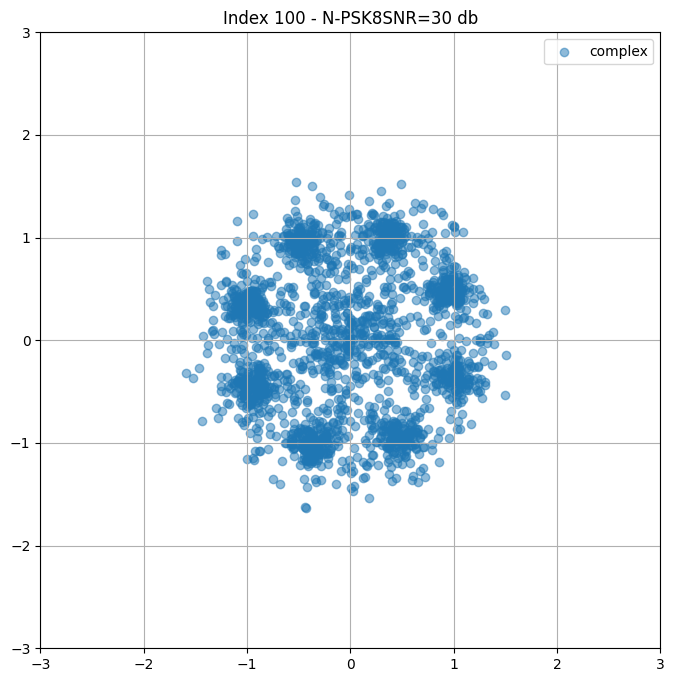

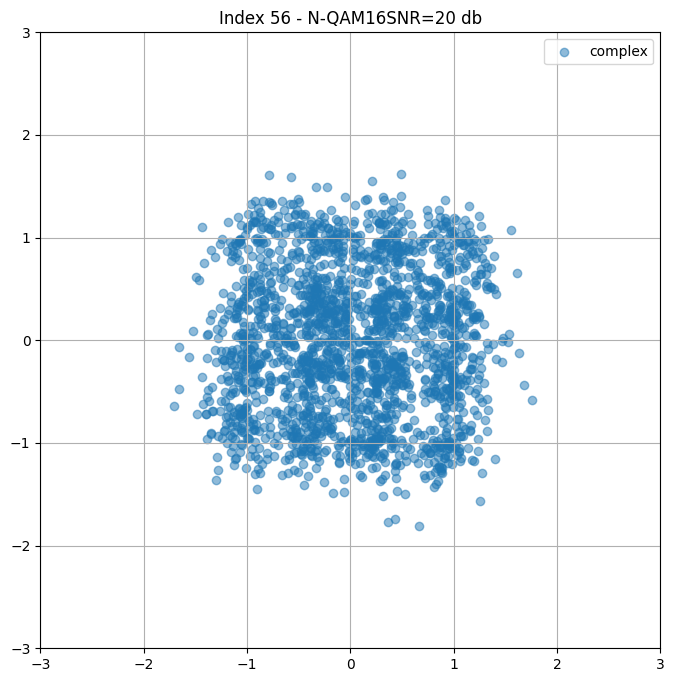

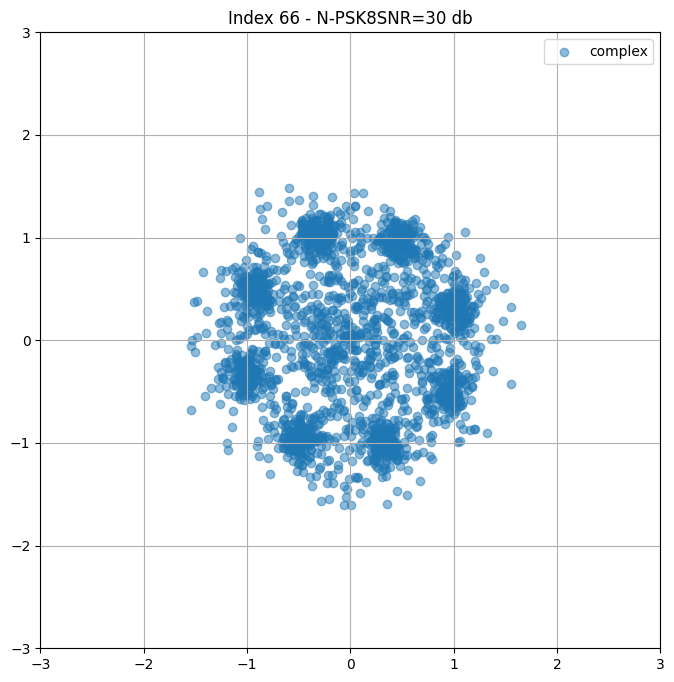

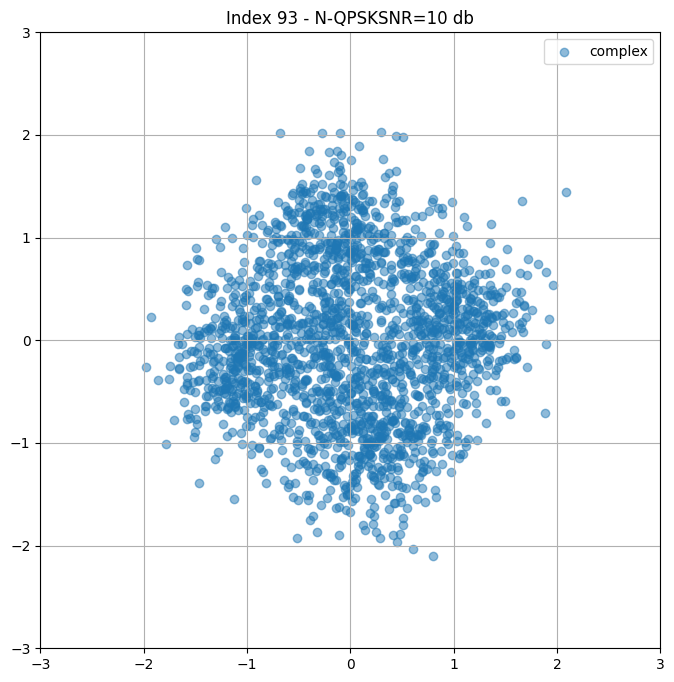

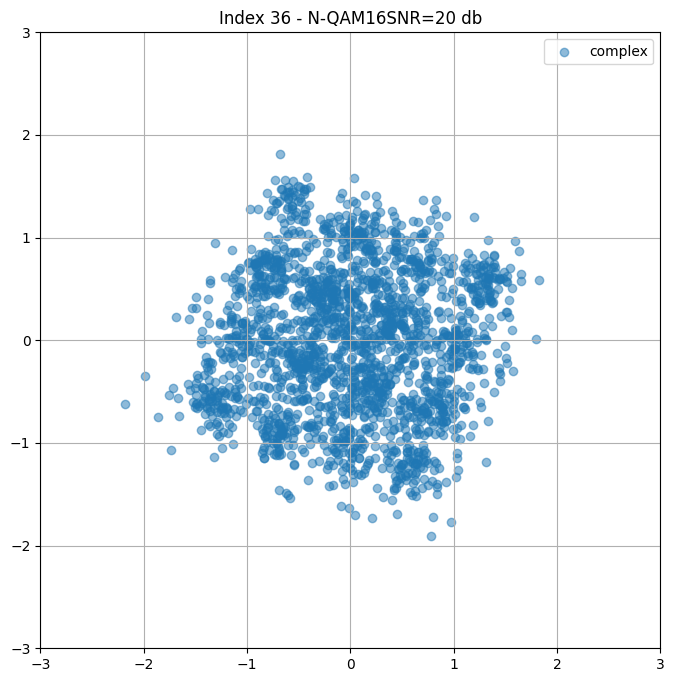

In [9]:
# % interactive visualization
data_in = [signals, snr, labels_id, label_dict]
if interactive_flag:
    interact(
        visualize_signals,
        data_in = fixed(data_in),
        idx=IntSlider(min=0, max=signals.shape[0]-1, step=1))
else:
    for idx in range(5):
        visualize_signals(data_in = data_in, idx=randint(0, signals.shape[0]-1))

In [10]:
# % check toy dataloader
from data_loader import get_data, SignalsDataset, SAMPLE_DATA_PATH
from torch.utils.data import DataLoader
N = 8  # batch size
C = 2 # number of channels
T = 2048 # signal length


dataset = SignalsDataset(SAMPLE_DATA_PATH)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
batch_signal, batch_labels = next(iter(train_dataloader))
assert batch_signal.shape == (N, C, T) # A batch shall be a 8, 2, 2048 tensor

## Vanilla classifier

In [ ]:
from model import VanillaClassifier
%load_ext autoreload
%autoreload 2

device = "cuda"
model = VanillaClassifier()
def sanity_check():
# model.to(device)
# Sanity check on inference
    pred = model(batch_signal)
    print(pred.shape, batch_labels.shape)
    import torch
    loss = torch.nn.CrossEntropyLoss()
    loss(pred, batch_labels[:, 0])

In [ ]:
from training import train
from data_loader import get_dataloaders
dataloaders = get_dataloaders()



In [ ]:
import torch
torch.cuda.is_available()

In [3]:
device = "cuda"
from training import train
from model import VanillaClassifier
model = VanillaClassifier()
model, training_losses, valid_losses, valid_accuracies  = train(model, batch_sizes=(256, 512), n_epochs=50)

Epoch 0: 100%|██████████| 118/118 [00:02<00:00, 51.62it/s]
/home/bneveu/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch=0 | training_loss=1.938 | valid_loss=1.9 | 18.250000%


Epoch 1: 100%|██████████| 118/118 [00:01<00:00, 61.05it/s]


epoch=1 | training_loss=1.874 | valid_loss=1.84 | 17.250000%


Epoch 2: 100%|██████████| 118/118 [00:01<00:00, 60.46it/s]


epoch=2 | training_loss=1.824 | valid_loss=1.81 | 19.380000%


Epoch 3: 100%|██████████| 118/118 [00:02<00:00, 58.85it/s]


epoch=3 | training_loss=1.804 | valid_loss=1.8 | 19.000000%


Epoch 4: 100%|██████████| 118/118 [00:02<00:00, 56.62it/s]


epoch=4 | training_loss=1.795 | valid_loss=1.79 | 18.660000%


Epoch 5: 100%|██████████| 118/118 [00:02<00:00, 58.89it/s]


epoch=5 | training_loss=1.789 | valid_loss=1.79 | 19.070000%


Epoch 6: 100%|██████████| 118/118 [00:01<00:00, 59.02it/s]


epoch=6 | training_loss=1.785 | valid_loss=1.78 | 19.890000%


Epoch 7: 100%|██████████| 118/118 [00:02<00:00, 55.15it/s]


epoch=7 | training_loss=1.781 | valid_loss=1.78 | 16.500000%


Epoch 8: 100%|██████████| 118/118 [00:02<00:00, 51.06it/s]


epoch=8 | training_loss=1.775 | valid_loss=1.77 | 18.590000%


Epoch 9: 100%|██████████| 118/118 [00:02<00:00, 55.26it/s]


epoch=9 | training_loss=1.766 | valid_loss=1.76 | 29.210000%


Epoch 10: 100%|██████████| 118/118 [00:01<00:00, 59.43it/s]


epoch=10 | training_loss=1.747 | valid_loss=1.73 | 32.410000%


Epoch 11: 100%|██████████| 118/118 [00:02<00:00, 58.47it/s]


epoch=11 | training_loss=1.715 | valid_loss=1.69 | 32.930000%


Epoch 12: 100%|██████████| 118/118 [00:02<00:00, 54.90it/s]


epoch=12 | training_loss=1.666 | valid_loss=1.63 | 33.340000%


Epoch 13: 100%|██████████| 118/118 [00:02<00:00, 58.33it/s]


epoch=13 | training_loss=1.598 | valid_loss=1.56 | 33.000000%


Epoch 14: 100%|██████████| 118/118 [00:02<00:00, 58.54it/s]


epoch=14 | training_loss=1.521 | valid_loss=1.49 | 33.350000%


Epoch 15: 100%|██████████| 118/118 [00:02<00:00, 58.98it/s]


epoch=15 | training_loss=1.447 | valid_loss=1.41 | 33.500000%


Epoch 16: 100%|██████████| 118/118 [00:01<00:00, 59.19it/s]


epoch=16 | training_loss=1.385 | valid_loss=1.36 | 32.840000%


Epoch 17: 100%|██████████| 118/118 [00:02<00:00, 57.66it/s]


epoch=17 | training_loss=1.336 | valid_loss=1.31 | 33.220000%


Epoch 18: 100%|██████████| 118/118 [00:02<00:00, 58.38it/s]


epoch=18 | training_loss=1.300 | valid_loss=1.28 | 34.230000%


Epoch 19: 100%|██████████| 118/118 [00:01<00:00, 59.07it/s]


epoch=19 | training_loss=1.273 | valid_loss=1.26 | 33.280000%


Epoch 20: 100%|██████████| 118/118 [00:02<00:00, 58.05it/s]


epoch=20 | training_loss=1.252 | valid_loss=1.24 | 33.990000%


Epoch 21: 100%|██████████| 118/118 [00:01<00:00, 60.24it/s]


epoch=21 | training_loss=1.236 | valid_loss=1.23 | 34.550000%


Epoch 22: 100%|██████████| 118/118 [00:02<00:00, 57.07it/s]


epoch=22 | training_loss=1.225 | valid_loss=1.22 | 34.710000%


Epoch 23: 100%|██████████| 118/118 [00:02<00:00, 57.73it/s]


epoch=23 | training_loss=1.215 | valid_loss=1.21 | 35.360000%


Epoch 24: 100%|██████████| 118/118 [00:02<00:00, 58.87it/s]


epoch=24 | training_loss=1.209 | valid_loss=1.2 | 34.450000%


Epoch 25: 100%|██████████| 118/118 [00:02<00:00, 57.29it/s]


epoch=25 | training_loss=1.201 | valid_loss=1.19 | 33.930000%


Epoch 26: 100%|██████████| 118/118 [00:01<00:00, 59.82it/s]


epoch=26 | training_loss=1.196 | valid_loss=1.19 | 34.750000%


Epoch 27: 100%|██████████| 118/118 [00:01<00:00, 59.19it/s]


epoch=27 | training_loss=1.191 | valid_loss=1.19 | 34.950000%


Epoch 28: 100%|██████████| 118/118 [00:02<00:00, 56.31it/s]


epoch=28 | training_loss=1.187 | valid_loss=1.18 | 35.370000%


Epoch 29: 100%|██████████| 118/118 [00:02<00:00, 57.71it/s]


epoch=29 | training_loss=1.184 | valid_loss=1.18 | 34.520000%


Epoch 30: 100%|██████████| 118/118 [00:02<00:00, 57.52it/s]


epoch=30 | training_loss=1.180 | valid_loss=1.18 | 34.770000%


Epoch 31: 100%|██████████| 118/118 [00:01<00:00, 59.22it/s]


epoch=31 | training_loss=1.178 | valid_loss=1.17 | 35.130000%


Epoch 32: 100%|██████████| 118/118 [00:02<00:00, 57.06it/s]


epoch=32 | training_loss=1.175 | valid_loss=1.17 | 33.500000%


Epoch 33: 100%|██████████| 118/118 [00:01<00:00, 59.06it/s]


epoch=33 | training_loss=1.173 | valid_loss=1.17 | 35.710000%


Epoch 34: 100%|██████████| 118/118 [00:01<00:00, 59.90it/s]


epoch=34 | training_loss=1.171 | valid_loss=1.17 | 34.910000%


Epoch 35: 100%|██████████| 118/118 [00:02<00:00, 56.74it/s]


epoch=35 | training_loss=1.169 | valid_loss=1.17 | 33.330000%


Epoch 36: 100%|██████████| 118/118 [00:02<00:00, 55.33it/s]


epoch=36 | training_loss=1.167 | valid_loss=1.16 | 34.140000%


Epoch 37: 100%|██████████| 118/118 [00:02<00:00, 59.00it/s]


epoch=37 | training_loss=1.165 | valid_loss=1.16 | 35.280000%


Epoch 38: 100%|██████████| 118/118 [00:02<00:00, 53.60it/s]


epoch=38 | training_loss=1.164 | valid_loss=1.16 | 35.190000%


Epoch 39: 100%|██████████| 118/118 [00:01<00:00, 60.05it/s]


epoch=39 | training_loss=1.162 | valid_loss=1.16 | 34.040000%


Epoch 40: 100%|██████████| 118/118 [00:02<00:00, 58.22it/s]


epoch=40 | training_loss=1.160 | valid_loss=1.16 | 34.330000%


Epoch 41: 100%|██████████| 118/118 [00:02<00:00, 54.24it/s]


epoch=41 | training_loss=1.159 | valid_loss=1.16 | 33.170000%


Epoch 42: 100%|██████████| 118/118 [00:02<00:00, 57.71it/s]


epoch=42 | training_loss=1.158 | valid_loss=1.15 | 35.200000%


Epoch 43: 100%|██████████| 118/118 [00:02<00:00, 57.30it/s]


epoch=43 | training_loss=1.156 | valid_loss=1.15 | 35.860000%


Epoch 44: 100%|██████████| 118/118 [00:02<00:00, 58.11it/s]


epoch=44 | training_loss=1.155 | valid_loss=1.15 | 36.120000%


Epoch 45: 100%|██████████| 118/118 [00:02<00:00, 58.72it/s]


epoch=45 | training_loss=1.155 | valid_loss=1.15 | 35.690000%


Epoch 46: 100%|██████████| 118/118 [00:02<00:00, 54.02it/s]


epoch=46 | training_loss=1.154 | valid_loss=1.15 | 35.570000%


Epoch 47: 100%|██████████| 118/118 [00:02<00:00, 56.24it/s]


epoch=47 | training_loss=1.152 | valid_loss=1.15 | 35.100000%


Epoch 48: 100%|██████████| 118/118 [00:01<00:00, 59.20it/s]


epoch=48 | training_loss=1.152 | valid_loss=1.15 | 35.010000%


Epoch 49: 100%|██████████| 118/118 [00:02<00:00, 57.97it/s]


epoch=49 | training_loss=1.150 | valid_loss=1.15 | 35.320000%


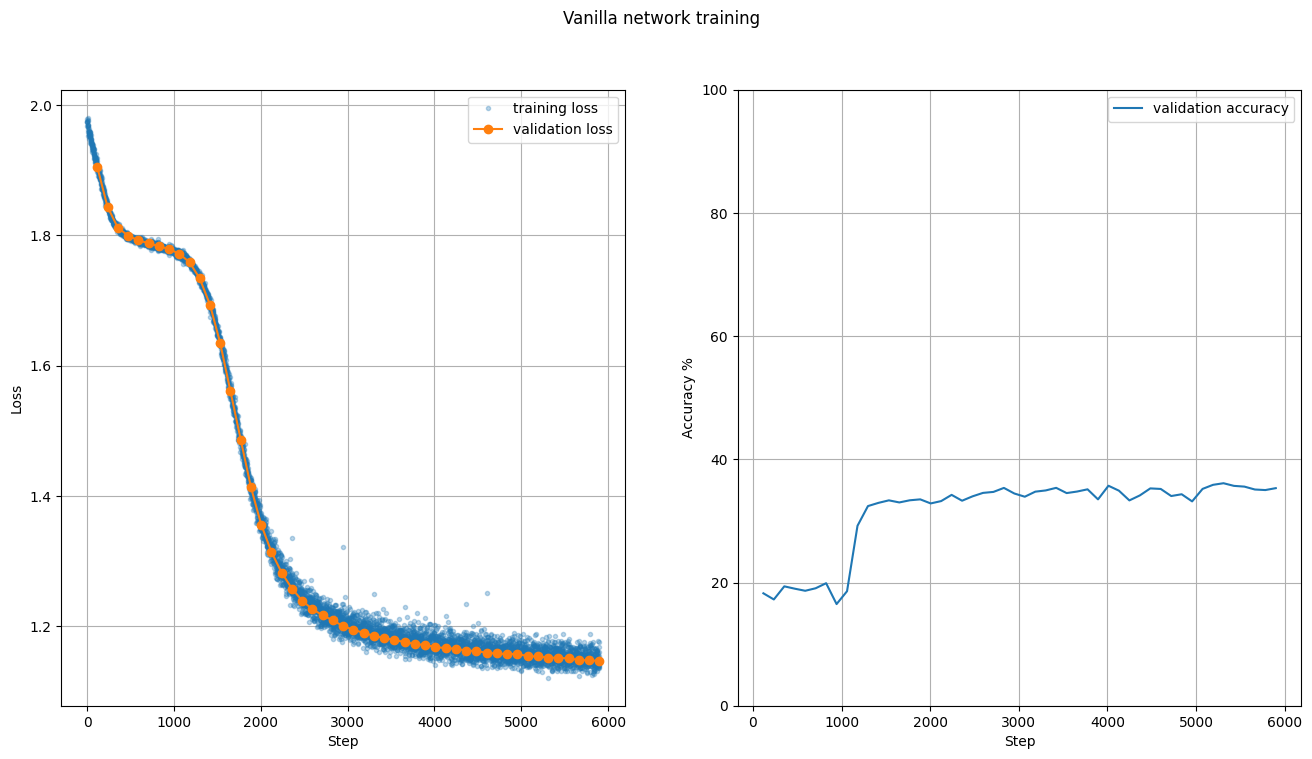

In [4]:
import matplotlib.pyplot as plt
import numpy as np
epoch_length = len(training_losses)/len(valid_losses)
epoch_steps = np.linspace(epoch_length, len(training_losses), len(valid_losses)) 

fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].plot(training_losses, ".", alpha=0.3, label="training loss")

axs[0].plot(epoch_steps, valid_losses,  "-o", label="validation loss")

axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].plot(epoch_steps, 100*np.array(valid_accuracies),  "-", label="validation accuracy")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Accuracy %")
axs[1].legend()
axs[1].grid()
axs[1].set_ylim(0, 100)
plt.suptitle("Vanilla network training")
plt.show()